In [6]:
!pip install transformers
!pip install numpy
!pip install torch
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install yfinance
!pip install seaborn
!pip install StandardScaler
!pip install xgboost
!pip install tensorflow

In [7]:

!pip install matplotlib

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from scipy.stats import ttest_rel
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.layers import Bidirectional, Reshape



#### All datasets are linked to GitHub repository so there is no requirement to locally link files. Datasets will still be included in the .zip file

# Preprocessing, EDA

## Original data set had around 25K observations, during group assignment we reduced it to 8K rows

In [9]:
data = pd.read_csv("https://media.githubusercontent.com/media/QBKFD/RNN-SENTIMENT-STOCK-MOVEMENT/refs/heads/main/final_df_sentiment.csv")
data.head(10)

,date,q,ticker,Prepared_remarks,Q&A,Q&A_Pos_Score,Q&A_Neg_Score,Q&A_Neutral_Score,Prepared_remarks_Pos_Score,Prepared_remarks_Neg_Score,Prepared_remarks_Neutral_Score
0,"May 05, 2021, 8:45 a.m. ET",2021-Q1,ABUS,Prepared Remarks:\nOperator\nLadies and gentle...,Questions & Answers:\nOperator\n[Operator inst...,0.045114,0.023523,0.931363,0.061609,0.022310,0.916081
1,"Jul 29, 2021, 4:30 p.m. ET",2021-Q2,FSLR,Prepared Remarks:\nOperator\nGood afternoon ev...,Questions & Answers:\nOperator\n[Operator inst...,0.060576,0.038685,0.900738,0.096557,0.066819,0.836624
2,"Aug 3, 2021, 10:00 a.m. ET",2021-Q2,RHP,Prepared Remarks:\nOperator\nHello. Welcome to...,Questions and Answers:\nOperator\n[Operator In...,0.057900,0.035296,0.906804,0.097533,0.060402,0.842066
3,"Jul 30, 2021, 9:00 a.m. ET",2021-Q2,ABBV,Prepared Remarks:\nOperator\nGood morning. Tha...,Questions & Answers:\nOperator\nOur first ques...,0.067040,0.023824,0.909137,0.265502,0.031018,0.703480
4,"Dec 19, 2019, 4:30 p.m. ET",2020-Q1,SGH,Prepared Remarks:\nOperator\nLadies and gentle...,Questions and Answers:\nOperator\n[Operator In...,0.057810,0.079277,0.862913,0.046332,0.075963,0.877704
5,"Feb 16, 2022, 4:30 p.m. ET",2022-Q2,CSCO,Prepared Remarks:\nOperator\nWelcome to Cisco'...,Questions & Answers:\nOperator\nThank you. Itt...,0.060164,0.035381,0.904455,0.253207,0.030567,0.716226
6,"Sep 5, 2019, 8:00 p.m. ET",2019-Q2,YRD,Prepared Remarks:\nOperator\nLadies and gentle...,Questions and Answers:\nOperator\n[Operator In...,0.073586,0.019384,0.907030,0.335034,0.050854,0.614112
7,"Nov 30, 2021, 4:30 p.m. ET",2021-Q4,HPE,"Prepared Remarks:\nOperator\nGood afternoon, a...",Questions & Answers:\nOperator\n[Operator inst...,0.065473,0.033449,0.901078,0.219201,0.037251,0.743548
8,"May 02, 2022, 5:00 p.m. ET",2022-Q1,RMBS,Prepared Remarks:\nOperator\nWelcome to the Ra...,Questions & Answers:\nOperator\nThank you. [Op...,0.057140,0.023767,0.919093,0.088620,0.042248,0.869132
9,"Apr 29, 2021, 11:00 a.m. ET",2021-Q1,GORO,Prepared Remarks:\nOperator\nThank you for sta...,Questions & Answers:\nOperator\nThank you. [Op...,0.047535,0.024356,0.928109,0.167035,0.069082,0.763882


### First approach, was to match tickers with historical stock price data. It was barely doable with existing free API's for the whole data set(final_df_sentiment) which has 8000 rows. 
### From the free ones, Yahoo Finance performed best. I was looking for an interface which will iterate through the whole data set. For many API's its barely doable.
### OpenAI and Gemini could not perform such actions, and web scraping would took too long to meet the set deadline

## Filtered COVID data

### Fetching Industry labels with the data

In [10]:

"""covid_data['Industry'] = None

for ticker in covid_data['ticker'].unique():
    try:
        # Fetch ticker information
        stock_info = yf.Ticker(ticker).info
        industry = stock_info.get('industry', 'Unknown')
        # Assign the industry to all rows with this ticker
        covid_data.loc[covid_data['ticker'] == ticker, 'Industry'] = industry
    except Exception as e:
        print(f"Error fetching industry for {ticker}: {e}")
        covid_data.loc[covid_data['ticker'] == ticker, 'Industry'] = 'Unknown'

labeled_file_path = '/Users/x/Downloads/price_data_with_industries.csv'
covid_data.to_csv(labeled_file_path, index=False)
"""

'covid_data[\'Industry\'] = None\n\nfor ticker in covid_data[\'ticker\'].unique():\n    try:\n        # Fetch ticker information\n        stock_info = yf.Ticker(ticker).info\n        industry = stock_info.get(\'industry\', \'Unknown\')\n        # Assign the industry to all rows with this ticker\n        covid_data.loc[covid_data[\'ticker\'] == ticker, \'Industry\'] = industry\n    except Exception as e:\n        print(f"Error fetching industry for {ticker}: {e}")\n        covid_data.loc[covid_data[\'ticker\'] == ticker, \'Industry\'] = \'Unknown\'\n\nlabeled_file_path = \'/Users/x/Downloads/price_data_with_industries.csv\'\ncovid_data.to_csv(labeled_file_path, index=False)\n'

In [11]:
data_ind = pd.read_csv("https://media.githubusercontent.com/media/QBKFD/RNN-SENTIMENT-STOCK-MOVEMENT/refs/heads/main/price_data_with_industries.csv")

In [12]:
data_ind

,Unnamed: 0,ticker,Industry,cleaned_date,month,q,Issue_Date_Price,Three_Days_Later_Price,Prepared_remarks_Pos_Score,Prepared_remarks_Neg_Score,COVID_Period,Stock_Change,Stock_Direction,dominant_sentiment
0,320,AGS,Gambling,2020-03-04,2020-03,2019-Q4,8.180000,6.210000,0.209537,0.090388,True,-1.970000,0,1
1,496,CARG,Auto & Truck Dealerships,2020-05-07,2020-05,2020-Q1,24.870001,24.250000,0.085948,0.101360,True,-0.620001,0,0
2,1118,FLS,Specialty Industrial Machinery,2021-08-06,2021-08,2021-Q2,37.171120,36.190983,0.240903,0.106431,False,-0.980137,0,1
3,139,AMBC,Insurance - Specialty,2019-11-08,2019-11,2019-Q3,20.690001,20.270000,0.142098,0.113355,False,-0.420000,0,1
4,1273,PRGS,Software - Infrastructure,2022-01-18,2022-01,2021-Q4,43.776154,42.908344,0.168394,0.027971,False,-0.867809,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,638,CEIX,Thermal Coal,2020-08-10,2020-08,2020-Q2,5.207294,4.947394,0.074103,0.172524,False,-0.259900,0,0
1437,710,GEOS,Oil & Gas Equipment & Services,2020-11-20,2020-11,2020-Q4,6.580000,6.550000,0.048440,0.453539,False,-0.030000,0,0
1438,1131,DQ,Semiconductor Equipment & Materials,2021-08-18,2021-08,2021-Q2,47.950001,47.080002,0.090055,0.028148,False,-0.869999,0,0
1439,302,ICUI,Medical Instruments & Supplies,2020-02-27,2020-02,2019-Q4,200.350006,200.770004,0.065664,0.068416,True,0.419998,1,0


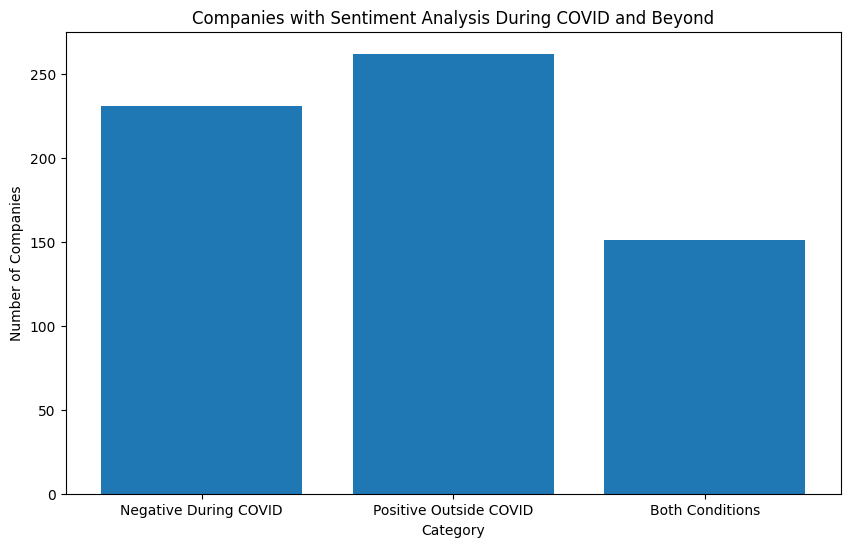

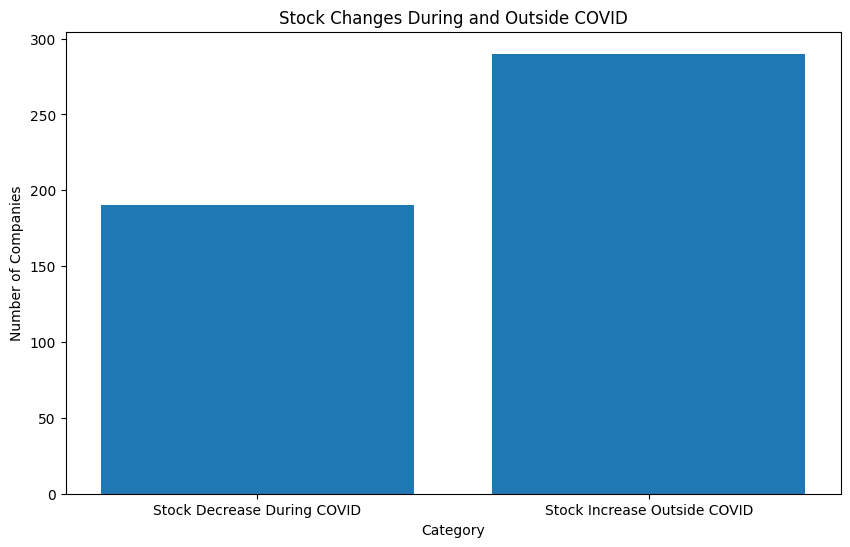

In [13]:
companies_covid_negative = set(data_ind[(data_ind['COVID_Period'] == True) & (data_ind['dominant_sentiment'] == 0)]['ticker'])
companies_non_covid_positive = set(data_ind[(data_ind['COVID_Period'] == False) & (data_ind['dominant_sentiment'] == 1)]['ticker'])

common_companies = companies_covid_negative.intersection(companies_non_covid_positive)

total_companies = len(data_ind['ticker'].unique())
only_covid_negative = len(companies_covid_negative)
only_non_covid_positive = len(companies_non_covid_positive)
both_conditions = len(common_companies)

categories = ['Negative During COVID', 'Positive Outside COVID', 'Both Conditions']
values = [only_covid_negative, only_non_covid_positive, both_conditions]

plt.figure(figsize=(10, 6))
plt.bar(categories, values)
plt.title("Companies with Sentiment Analysis During COVID and Beyond")
plt.ylabel("Number of Companies")
plt.xlabel("Category")
plt.show()

data_ind['Stock_Change'] = data_ind['Three_Days_Later_Price'] - data_ind['Issue_Date_Price']

covid_stock_decrease = data_ind[(data_ind['COVID_Period'] == True) & (data_ind['Stock_Change'] < 0)]
covid_stock_increase = data_ind[(data_ind['COVID_Period'] == True) & (data_ind['Stock_Change'] > 0)]

non_covid_stock_decrease = data_ind[(data_ind['COVID_Period'] == False) & (data_ind['Stock_Change'] < 0)]
non_covid_stock_increase = data_ind[(data_ind['COVID_Period'] == False) & (data_ind['Stock_Change'] > 0)]

covid_stock_decrease_count = covid_stock_decrease['ticker'].nunique()
non_covid_stock_increase_count = non_covid_stock_increase['ticker'].nunique()

categories = ['Stock Decrease During COVID', 'Stock Increase Outside COVID']
values = [covid_stock_decrease_count, non_covid_stock_increase_count]

plt.figure(figsize=(10, 6))
plt.bar(categories, values)
plt.title("Stock Changes During and Outside COVID")
plt.ylabel("Number of Companies")
plt.xlabel("Category")
plt.show()


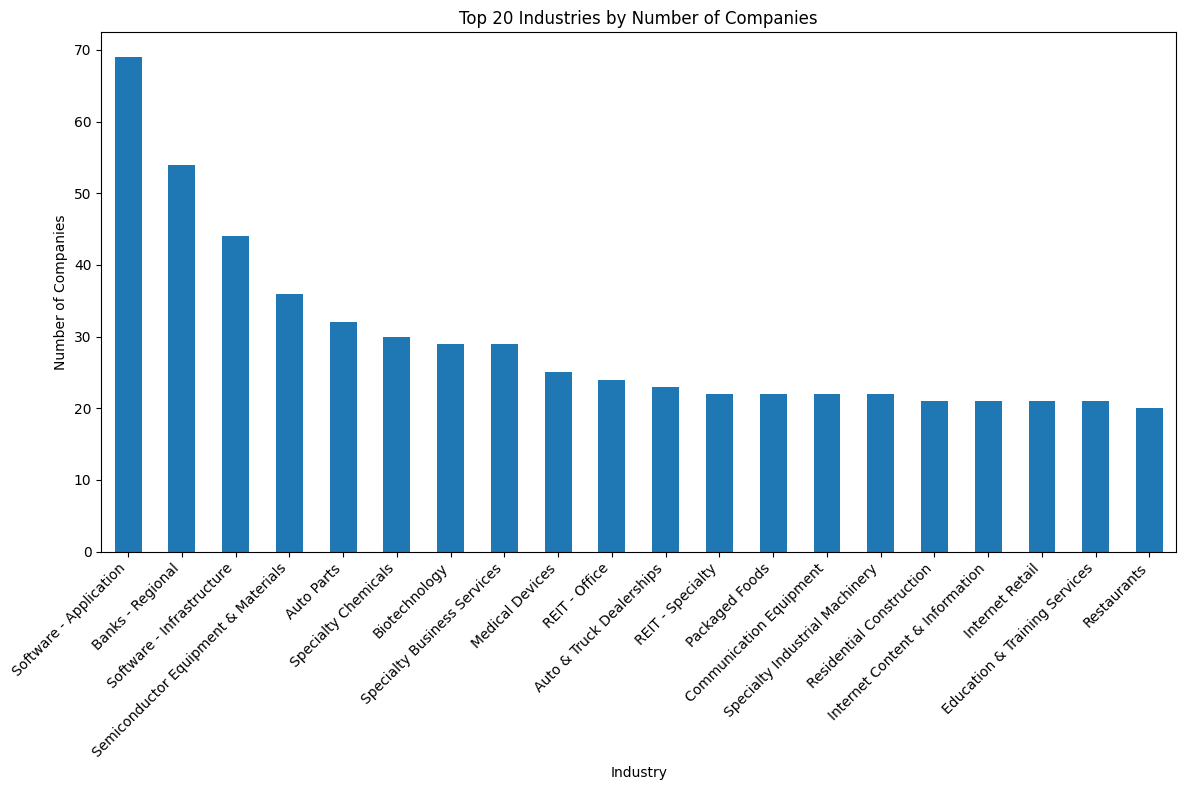

In [14]:
industry_counts = data_ind['Industry'].value_counts()

top_industries = industry_counts.head(20)  # Display only the top 10 industries for clarity

plt.figure(figsize=(12, 8))
top_industries.plot(kind='bar')
plt.title("Top 20 Industries by Number of Companies")
plt.ylabel("Number of Companies")
plt.xlabel("Industry")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Moreover, I assigned macroeconomic indicators to selected industries which could increase/decrease stock due to Joe Biden's election.

### Industries Likely to Increase

#### Software - Application and Infrastructure:
Biden's administration places strong emphasis on technology, cybersecurity, and digital transformation. Federal investments in these areas can boost software-related industries.

#### Semiconductor Equipment & Materials:
Biden has highlighted the importance of semiconductor manufacturing as critical to U.S. economic security. Investments and policies supporting domestic semiconductor production could lead to growth in this sector.

#### Biotechnology and Medical Devices:
With a focus on healthcare reforms and advancing medical technologies, these sectors could benefit from increased funding and demand.

#### Specialty Chemicals:
Biden's environmental policies, including those targeting sustainable materials and clean energy, could increase demand for innovative chemical solutions in renewable energy and sustainable manufacturing.

#### Auto Parts and Auto & Truck Dealerships:
Biden's push for electric vehicles (EVs) and incentives for EV adoption could boost the automotive industry, especially those aligned with EV production.

#### REITs - Office and Specialty:
As the economy stabilizes post-pandemic, real estate investment trusts (REITs), especially those in office and industrial spaces, could benefit from economic recovery efforts and policy measures promoting infrastructure investment.

---

### Industries Likely to Decrease

#### Packaged Foods and Restaurants:
These sectors may face challenges from increased labor costs due to Biden's push for higher minimum wages and stricter labor regulations.

#### Internet Content & Information:
Increased scrutiny on big tech and content platforms for antitrust concerns and misinformation might create regulatory pressures, potentially slowing growth.

#### Banks - Regional:
While financial services often adapt to changing conditions, Biden's policies on tax reforms and increased regulation on financial institutions may create a more challenging environment for regional banks.

---

### Neutral/Uncertain Impacts

#### Education & Training Services:
Biden's policies on education funding and student loan forgiveness might have indirect effects, but the specifics for private education companies are unclear.

#### Residential Construction:
While Biden has pledged to invest in affordable housing, rising material costs and potential regulatory changes could counterbalance the positive impacts.


### Binary feature

In [15]:
# List of industries expected to increase based on the analysis
industries_increase = [
    "Software - Application", 
    "Software - Infrastructure",
    "Semiconductor Equipment & Materials",
    "Biotechnology",
    "Medical Devices",
    "Specialty Chemicals",
    "Auto Parts",
    "REIT - Office",
    "REIT - Specialty"
]

data_ind['Election_Impact_Binary'] = data_ind['Industry'].apply(lambda x: 1 if x in industries_increase else 0)


Logistic Regression Results:
Accuracy: 0.5473
ROC-AUC: 0.5135
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.14      0.20       179
           1       0.58      0.83      0.68       254

    accuracy                           0.55       433
   macro avg       0.48      0.49      0.44       433
weighted avg       0.49      0.55      0.49       433


Random Forest Results:
Accuracy: 0.4688
ROC-AUC: 0.4503
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.38      0.37       179
           1       0.55      0.53      0.54       254

    accuracy                           0.47       433
   macro avg       0.46      0.46      0.46       433
weighted avg       0.47      0.47      0.47       433


XGBoost Results:
Accuracy: 0.5035
ROC-AUC: 0.5023
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.44      0.42       1

/Users/x/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:17:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


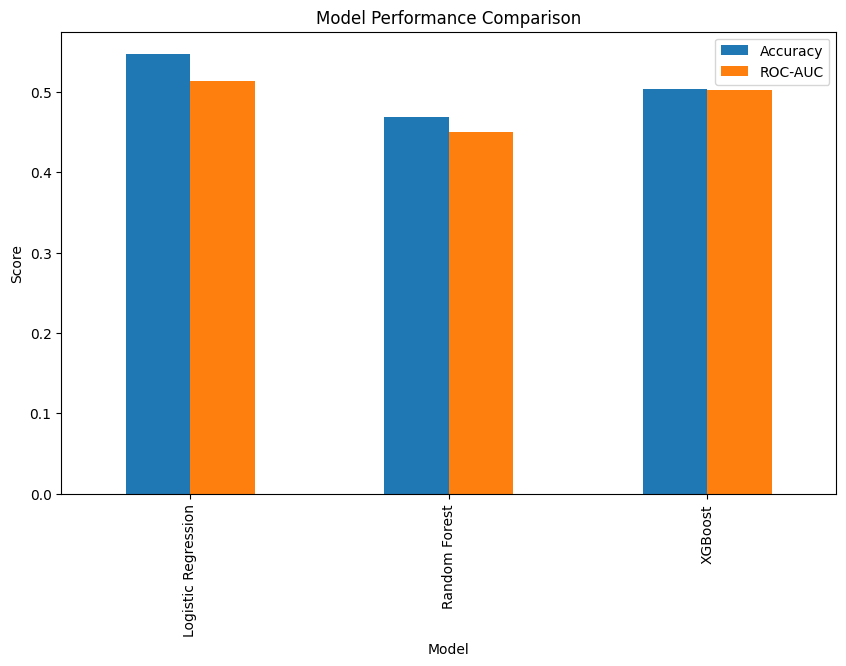

In [16]:
data_ind['cleaned_date'] = pd.to_datetime(data_ind['cleaned_date'])
data_ind['COVID_Period'] = data_ind['cleaned_date'].between('2019-09-01', '2020-06-30')
data_ind['Stock_Change'] = data_ind['Three_Days_Later_Price'] - data_ind['Issue_Date_Price']
data_ind['Stock_Direction'] = (data_ind['Stock_Change'] > 0).astype(int)

features = ['Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score', 'COVID_Period', 'dominant_sentiment', 'Election_Impact_Binary']
X = data_ind[features]
y = data_ind['Stock_Direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------- Logistic Regression ----------------
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
logistic_roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

print("\nLogistic Regression Results:")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"ROC-AUC: {logistic_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# ---------------- Random Forest ----------------
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# ---------------- Gradient Boosting (e.g., XGBoost) ----------------

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("\nXGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"ROC-AUC: {xgb_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nSummary of Model Performance:")
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [logistic_accuracy, rf_accuracy, xgb_accuracy],
    "ROC-AUC": [logistic_roc_auc, rf_roc_auc, xgb_roc_auc]
})
print(results)

results.set_index("Model").plot(kind='bar', figsize=(10, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.show()


## Correlation

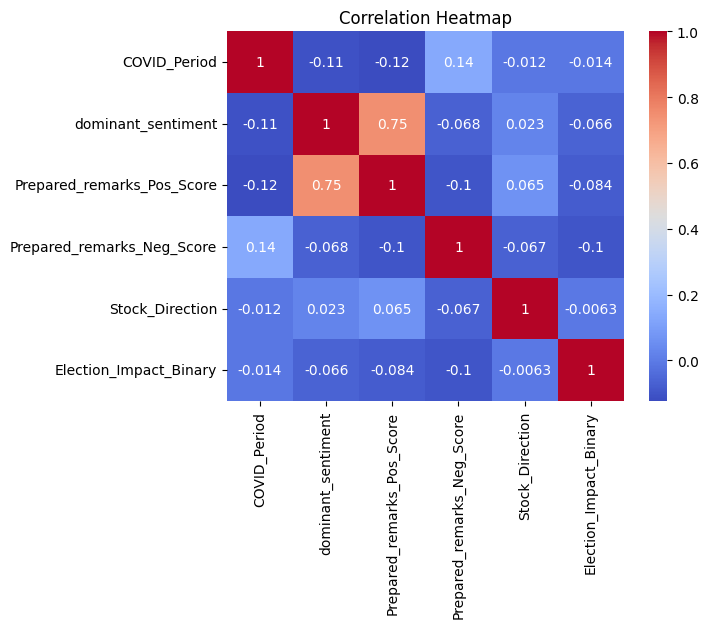

In [17]:
correlation_matrix = data_ind[['COVID_Period','dominant_sentiment', 'Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score', 'Stock_Direction','Election_Impact_Binary']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## Chi Square Tests

In [18]:
contingency_table = pd.crosstab(data_ind['COVID_Period'], data_ind['dominant_sentiment'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
if p < 0.05:
    print("COVID Period is likely to have an influence on Dominant Sentiment (statistically significant).")
else:
    print("No significant relationship between COVID_Period and Dominant Sentiment.")


Chi-Square Statistic: 15.90180068929537
P-value: 6.671521316694849e-05
COVID Period is likely to have an influence on Dominant Sentiment (statistically significant).


In [19]:
contingency_table = pd.crosstab(data_ind['COVID_Period'], data_ind['Stock_Direction'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
if p < 0.05:
    print("COVID Period is likely to have an influence on Stock Direction (statistically significant).")
else:
    print("No significant relationship between COVID_Period and Stock_Direction.")


Chi-Square Statistic: 0.1492295104811315
P-value: 0.6992727556237406
No significant relationship between COVID_Period and Stock_Direction.


# Only SP500, 10 days prior

### Merging with SP500 dataframe to use Election_Impact_Binary feature. It is very likely, that presidential election had impact outside of the US but for now I have assumed that it does not

In [20]:
sp500_path = "https://media.githubusercontent.com/media/QBKFD/RNN-SENTIMENT-STOCK-MOVEMENT/refs/heads/main/SP500.csv"
sp500_data = pd.read_csv(sp500_path)
sp500_tickers = sp500_data['Symbol'].unique()

filtered_data = data_ind[data_ind['ticker'].isin(sp500_tickers)]



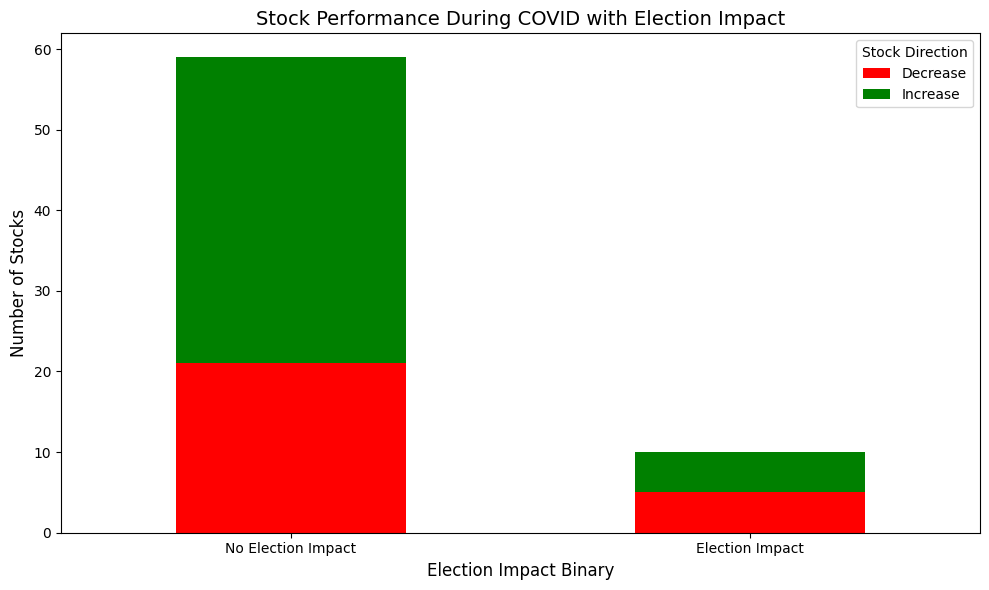

In [21]:

# Filtering data for COVID period and grouping by Election Impact and Stock Direction
covid_election_data = filtered_data[filtered_data['COVID_Period'] == True].groupby(
    ['Election_Impact_Binary', 'Stock_Direction']).size().unstack(fill_value=0)

# Election Impact labels
election_labels = ['No Election Impact', 'Election Impact']

# Bar Chart Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for stock directions with and without election impact during COVID
covid_election_data.plot(kind='bar', stacked=True, color=['red', 'green'], ax=ax)

ax.set_title("Stock Performance During COVID with Election Impact", fontsize=14)
ax.set_xlabel("Election Impact Binary", fontsize=12)
ax.set_ylabel("Number of Stocks", fontsize=12)
ax.set_xticklabels(election_labels, rotation=0)
ax.legend(["Decrease", "Increase"], title="Stock Direction")

plt.tight_layout()
plt.show()


### Fetching the data using YF Api

In [22]:

filtered_data['cleaned_date'] = pd.to_datetime(filtered_data['cleaned_date'])

def fetch_prices_for_days(ticker, target_date, num_days=10):
    try:
        # Add a buffer for data fetching
        start_date = target_date - pd.Timedelta(days=num_days + 1)
        end_date = target_date

        # Fetch stock data
        stock = yf.Ticker(ticker)
        historical_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        # Ensure the index is tz-naive
        historical_data.index = historical_data.index.tz_localize(None)

        prices = {}
        
        for i in range(num_days, 0, -1):
            check_date = target_date - pd.Timedelta(days=i)
            if not historical_data.empty:
                # Calculate the closest available date
                historical_data['diff'] = abs(historical_data.index - check_date)
                closest_row = historical_data.loc[historical_data['diff'].idxmin()]
                prices[f'price_{i}_days_before'] = closest_row['Close']
            else:
                prices[f'price_{i}_days_before'] = None  # No data
        
        return prices
    except Exception as e:
        print(f"Error fetching data for {ticker} on {target_date}: {e}")
        return {f'price_{i}_days_before': None for i in range(num_days, 0, -1)}

price_data = filtered_data.apply(lambda row: fetch_prices_for_days(row['ticker'], row['cleaned_date']), axis=1)

price_data_df = pd.DataFrame(price_data.tolist())

filtered_data = pd.concat([filtered_data.reset_index(drop=True), price_data_df], axis=1)


/var/folders/j5/wrgs7dkx0h5ftr4gsr51y6xm0000gn/T/ipykernel_6793/1858638124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cleaned_date'] = pd.to_datetime(filtered_data['cleaned_date'])


In [23]:
filtered_data = filtered_data.loc[:, ~filtered_data.columns.duplicated()]

price_columns = [
    'price_10_days_before', 'price_9_days_before', 'price_8_days_before',
    'price_7_days_before', 'price_6_days_before', 'price_5_days_before',
    'price_4_days_before', 'price_3_days_before', 'price_2_days_before',
    'price_1_days_before'
]
sentiment_columns = ['Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score', 'dominant_sentiment']
static_columns = ['COVID_Period', 'Election_Impact_Binary']
target_column = 'Stock_Direction'

filtered_data = filtered_data.dropna(subset=price_columns + sentiment_columns + static_columns + [target_column])

filtered_data['COVID_Period'] = filtered_data['COVID_Period'].astype(int)

scaler_prices = MinMaxScaler()
scaler_sentiments = MinMaxScaler()

prices_scaled = scaler_prices.fit_transform(filtered_data[price_columns])
sentiments_scaled = scaler_sentiments.fit_transform(filtered_data[sentiment_columns])
static_features = filtered_data[static_columns].values  # No scaling for binary features

prices_scaled = prices_scaled.reshape(-1, len(price_columns), 1)  # Shape: (samples, 10, 1)

sentiments_scaled = np.repeat(sentiments_scaled[:, np.newaxis, :], len(price_columns), axis=1)  # (samples, 10, 3)
static_features = np.repeat(static_features[:, np.newaxis, :], len(price_columns), axis=1)  # (samples, 10, 2)

X = np.concatenate([prices_scaled, sentiments_scaled, static_features], axis=2)
y = filtered_data[target_column].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# LSTM

### Model

### Model

In [24]:
#LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))  # High dropout to prevent overfitting
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)  # You can adjust to 0.0001 or 0.01 if needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Increased epochs for better convergence
    batch_size=32,  # Smaller batch size for better gradient updates
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/100


/Users/x/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5164 - loss: 0.6924 - val_accuracy: 0.4769 - val_loss: 0.6954
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6139 - loss: 0.6856 - val_accuracy: 0.4462 - val_loss: 0.6942
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5400 - loss: 0.6903 - val_accuracy: 0.4462 - val_loss: 0.6928
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5411 - loss: 0.6861 - val_accuracy: 0.4769 - val_loss: 0.6917
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5861 - loss: 0.6870 - val_accuracy: 0.5385 - val_loss: 0.6908
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5762 - loss: 0.6849 - val_accuracy: 0.5231 - val_loss: 0.6901
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5981 - loss: 0.6804 - val_accuracy: 0.5385 - val_loss: 0.6896
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6206 - loss: 0.6773 - val_accuracy: 0.5385 - val_loss: 0.6890
Epoc

# RF

In [25]:

feature_columns = [
  # Use dominant sentiment instead of detailed scores
    'Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score','dominant_sentiment','COVID_Period', 'Election_Impact_Binary',
    'price_10_days_before', 'price_9_days_before', 'price_8_days_before',
    'price_7_days_before', 'price_6_days_before', 'price_5_days_before',
    'price_4_days_before', 'price_3_days_before', 'price_2_days_before',
    'price_1_days_before'
]
target_column = 'Stock_Direction'

X = filtered_data[feature_columns]
y = filtered_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = model.feature_importances_
print("\nFeature Importance:")
for feature, importance in zip(feature_columns, importances):
    print(f"{feature}: {importance:.4f}")


Accuracy: 0.4419
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.24      0.25        17
           1       0.54      0.58      0.56        26

    accuracy                           0.44        43
   macro avg       0.40      0.41      0.40        43
weighted avg       0.43      0.44      0.43        43

Confusion Matrix:
[[ 4 13]
 [11 15]]

Feature Importance:
Prepared_remarks_Pos_Score: 0.1012
Prepared_remarks_Neg_Score: 0.1211
dominant_sentiment: 0.0139
COVID_Period: 0.0085
Election_Impact_Binary: 0.0166
price_10_days_before: 0.0732
price_9_days_before: 0.0685
price_8_days_before: 0.0729
price_7_days_before: 0.0712
price_6_days_before: 0.0705
price_5_days_before: 0.0749
price_4_days_before: 0.0753
price_3_days_before: 0.0852
price_2_days_before: 0.0782
price_1_days_before: 0.0690


In [26]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Accuracy: 0.4884


# __________________________________________________________________________________________________________________________________________________________________

# 30 days range

### Fetchinng the data using YF Api 

In [27]:
data_ind['cleaned_date'] = pd.to_datetime(data_ind['cleaned_date'])

def fetch_prices_for_days(ticker, target_date, num_days=30):  # Fetch 30 days of prices
    try:
        start_date = target_date - pd.Timedelta(days=num_days + 1)
        end_date = target_date

        stock = yf.Ticker(ticker)
        historical_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        historical_data.index = historical_data.index.tz_localize(None)

        prices = {}
        
        for i in range(num_days, 0, -1):  # Loop through 30 days
            check_date = target_date - pd.Timedelta(days=i)
            if not historical_data.empty:
                # Calculate the closest available date
                historical_data['diff'] = abs(historical_data.index - check_date)
                closest_row = historical_data.loc[historical_data['diff'].idxmin()]
                prices[f'price_{i}_days_before'] = closest_row['Close']
            else:
                prices[f'price_{i}_days_before'] = None  # No data
        
        return prices
    except Exception as e:
        print(f"Error fetching data for {ticker} on {target_date}: {e}")
        # Return None for all days in case of an error
        return {f'price_{i}_days_before': None for i in range(num_days, 0, -1)}

price_data = data_ind.apply(lambda row: fetch_prices_for_days(row['ticker'], row['cleaned_date']), axis=1)

price_data_df = pd.DataFrame(price_data.tolist())

data_ind = pd.concat([data_ind.reset_index(drop=True), price_data_df], axis=1)

print(data_ind.head())


$HAYN: possibly delisted; no price data found  (1d 2019-12-31 -> 2020-01-31) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for HAYN on 2020-01-31 00:00:00: 'Index' object has no attribute 'tz_localize'


$HAYN: possibly delisted; no price data found  (1d 2021-03-30 -> 2021-04-30) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for HAYN on 2021-04-30 00:00:00: 'Index' object has no attribute 'tz_localize'


$HAYN: possibly delisted; no price data found  (1d 2020-06-30 -> 2020-07-31) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for HAYN on 2020-07-31 00:00:00: 'Index' object has no attribute 'tz_localize'
   Unnamed: 0 ticker                        Industry cleaned_date    month  \
0         320    AGS                        Gambling   2020-03-04  2020-03   
1         496   CARG        Auto & Truck Dealerships   2020-05-07  2020-05   
2        1118    FLS  Specialty Industrial Machinery   2021-08-06  2021-08   
3         139   AMBC           Insurance - Specialty   2019-11-08  2019-11   
4        1273   PRGS       Software - Infrastructure   2022-01-18  2022-01   

         q  Issue_Date_Price  Three_Days_Later_Price  \
0  2019-Q4          8.180000                6.210000   
1  2020-Q1         24.870001               24.250000   
2  2021-Q2         37.171120               36.190983   
3  2019-Q3         20.690001               20.270000   
4  2021-Q4         43.776154               42.908344   

   Prepared_remarks_Pos_Score  Prepared_remarks_Neg_Score  ...  \
0                    0.209537

### Assigning stock direction by percentage. If stock increases over 2% its defined as an increasing stock, and if it's decreasing over 2% its defined as a decreasing one.

In [28]:
data_ind['Average_30_Day_Price'] = data_ind[[f'price_{i}_days_before' for i in range(1, 31)]].mean(axis=1)

# Calculate percentage change relative to the 30-day average
data_ind['Price_Change_Percent'] = (
    (data_ind['Issue_Date_Price'] - data_ind['Average_30_Day_Price']) / data_ind['Average_30_Day_Price']
) * 100

# Define Stock_Direction and Neutral_Change
def determine_stock_direction(change):
    if change > 2:
        return 1  # Positive direction
    elif change < -2:
        return 0  # Negative direction
    else:
        return None

def is_neutral_change(change):
    return -2 <= change <= 2

data_ind['Stock_Direction'] = data_ind['Price_Change_Percent'].apply(determine_stock_direction)
data_ind['Neutral_Change'] = data_ind['Price_Change_Percent'].apply(is_neutral_change).astype(int)

data_ind = data_ind.dropna(subset=['Stock_Direction']).reset_index(drop=True)

data_ind['Stock_Direction'] = data_ind['Stock_Direction'].astype(int)



### Train-test split

In [29]:
data_ind['COVID_Period'] = data_ind['COVID_Period'].astype(int)


# Time-series features (30 days of prices)
time_series_columns = [f'price_{i}_days_before' for i in range(1, 31)]
X_time_series = data_ind[time_series_columns].values.reshape(-1, 30, 1)

# Static features
static_columns = [
    'dominant_sentiment','Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score',  'COVID_Period', 'Election_Impact_Binary',]
X_static = data_ind[static_columns].values
y = data_ind['Stock_Direction'].values


X_time_train, X_time_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_time_series, X_static, y, test_size=0.2, random_state=42
)


### Each of the models has selected parameters individually to increase the performance

# __________________________________________________________________________________________________________________________________________________________________

# CNN

### Model

In [30]:
time_input = Input(shape=(X_time_train.shape[1], X_time_train.shape[2]))  # Time-series input
static_input = Input(shape=(X_static_train.shape[1],))  # Static features input

x = Conv1D(filters=64, kernel_size=3, activation='relu')(time_input)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

combined = Concatenate()([x, static_input])

combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.4)(combined)
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation='sigmoid')(combined)  # Binary classification output

cnn_model = Model(inputs=[time_input, static_input], outputs=output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate if needed
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn_history = cnn_model.fit(
    [X_time_train, X_static_train], y_train,
    epochs=50, batch_size=32,
    validation_data=([X_time_test, X_static_test], y_test),callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5034 - loss: 4.7712 - val_accuracy: 0.6101 - val_loss: 1.6356
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5271 - loss: 3.5670 - val_accuracy: 0.6101 - val_loss: 0.8593
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5377 - loss: 2.0233 - val_accuracy: 0.6101 - val_loss: 0.8884
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5144 - loss: 1.7082 - val_accuracy: 0.4817 - val_loss: 0.7364
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4632 - loss: 1.5771 - val_accuracy: 0.6239 - val_loss: 0.7031
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5784 - loss: 1.2738 - val_accuracy: 0.7110 - val_loss: 0.6523
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5305 - loss: 1.0361 - val_accuracy: 0.6330 - val_loss: 0.6774
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5647 - loss: 0.9680 - val_accuracy: 0.5596 - val_loss: 0.6997
Epo

In [31]:

y_pred_prob = cnn_model.predict([X_time_test, X_static_test])  
y_pred = (y_pred_prob > 0.5).astype(int)  

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob) 

print(f"Final Model Metrics:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc_roc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Final Model Metrics:
Test Accuracy: 0.7294
Test Precision: 0.6989
Test Recall: 0.9774
Test F1 Score: 0.8150
Test AUC-ROC: 0.8621


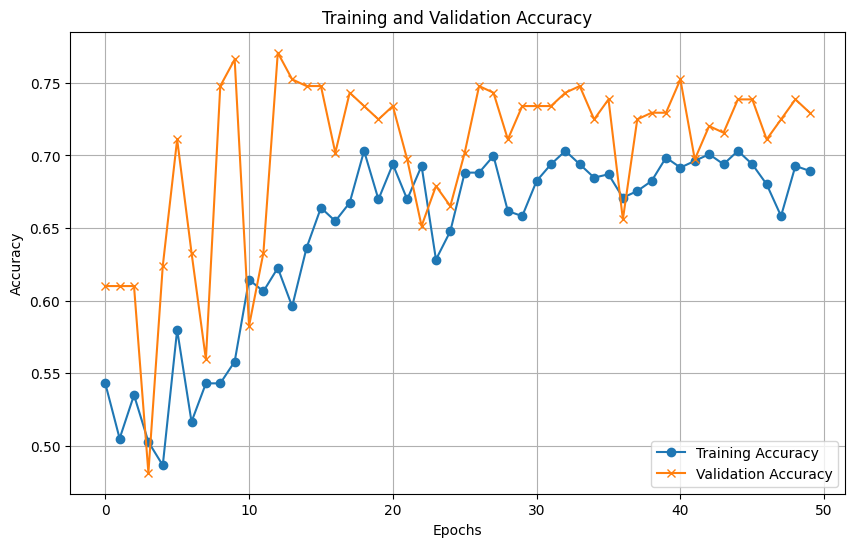

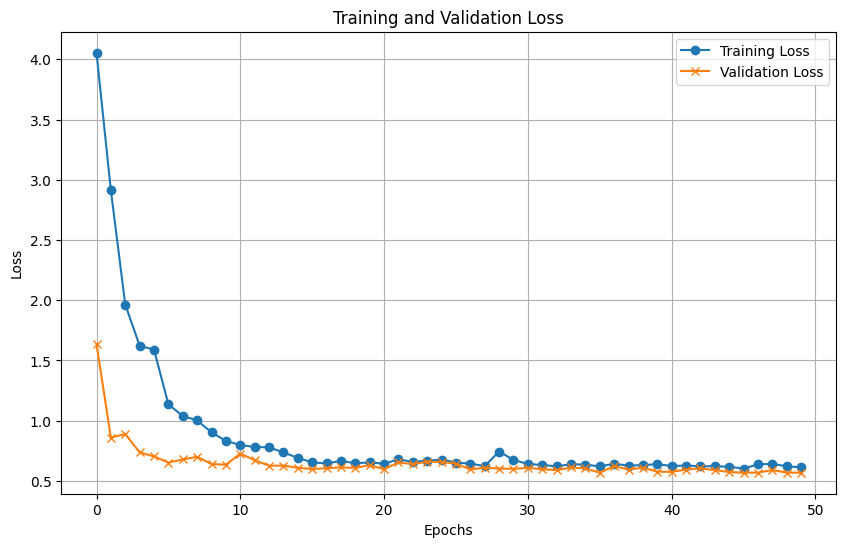

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss', marker='o')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Training Performance Analysis

### Training and Validation Accuracy
The first plot shows the **training and validation accuracy** over **10 epochs**. Observations:
- The **training accuracy** (blue line) remains relatively stable with slight fluctuations.
- The **validation accuracy** (orange line) shows high variance, with a sharp drop at epoch 4 before recovering.

### Training and Validation Loss
The second plot displays the **training and validation loss** trends.
- The **training loss** (blue) decreases consistently, suggesting the model is learning.
- The **validation loss** (orange) remains relatively stable but increases slightly around epoch 4.



# GRU

### Model

#### GRU is used as a test and I would not consider it 100% reliable model for this case. 

##### -Static features (e.g., sentiment, COVID impact) do not change over time but are being repeated 30 times.
##### -This may cause redundant information in each timestep, making it harder for the GRU to differentiate temporal dependencies from static context.


In [33]:
X_train = np.concatenate([X_time_train, np.expand_dims(X_static_train, axis=1).repeat(30, axis=1)], axis=2)
X_test = np.concatenate([X_time_test, np.expand_dims(X_static_test, axis=1).repeat(30, axis=1)], axis=2)

In [34]:
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))  # High dropout to prevent overfitting
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20


/Users/x/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5424 - loss: 0.7387 - val_accuracy: 0.6101 - val_loss: 0.6568
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5636 - loss: 0.7124 - val_accuracy: 0.6101 - val_loss: 0.6625
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5837 - loss: 0.6950 - val_accuracy: 0.6101 - val_loss: 0.6637
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5982 - loss: 0.7113 - val_accuracy: 0.6055 - val_loss: 0.6582
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5737 - loss: 0.6861 - val_accuracy: 0.6193 - val_loss: 0.6610
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6328 - loss: 0.6650 - val_accuracy: 0.6330 - val_loss: 0.6533
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6011 - loss: 0.6604 - val_accuracy: 0.5826 - val_loss: 0.6730
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5937 - loss: 0.6813 - val_accuracy: 0.6055 - val_loss: 0.

## Training Performance Analysis

### Training and Validation Accuracy
The first plot illustrates the **training and validation accuracy** over **40 epochs**:
- The **training accuracy** (blue line) shows a consistent upward trend, indicating the model is learning.
- The **validation accuracy** (orange line) fluctuates significantly, especially around epochs 25-30, showing minor instability.
- Toward the end, both training and validation accuracy converge, suggesting improved generalization.

### Training and Validation Loss
The second plot depicts the **training and validation loss** progression:
- The **training loss** (blue) decreases gradually, as expected.
- The **validation loss** (orange) is relatively stable but has **spikes** around epochs 25-30.
- In the later epochs, both training and validation losses decrease and converge, which is a good sign.



## RNN

### Recurrent Neural Networks (RNNs) are designed to process sequential data by maintaining a memory of past inputs.

In [35]:
time_input = Input(shape=(30, 1), name="time_input")

x = SimpleRNN(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(time_input)
x = SimpleRNN(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(x)

static_input = Input(shape=(X_static_train.shape[1],), name="static_input")
combined = Concatenate()([x, static_input])
combined = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.4)(combined)
combined = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.3)(combined)

output = Dense(1, activation='sigmoid', name="output")(combined)

model = Model(inputs=[time_input, static_input], outputs=output)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Clip gradients for stability
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=1e-5)
history = model.fit(
    [X_time_train, X_static_train], y_train,  
    epochs=100,
    batch_size=32,
    validation_data=([X_time_test, X_static_test], y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

loss, accuracy = model.evaluate([X_time_test, X_static_test], y_test, verbose=0)

print(f"\nFinal Model Performance:")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4737 - loss: 2.7156 - val_accuracy: 0.4954 - val_loss: 2.3491 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5604 - loss: 2.4808 - val_accuracy: 0.6101 - val_loss: 2.2388 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5505 - loss: 2.3888 - val_accuracy: 0.6101 - val_loss: 2.1446 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5369 - loss: 2.3049 - val_accuracy: 0.6101 - val_loss: 2.0547 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5667 - loss: 2.1893 - val_accuracy: 0.6101 - val_loss: 1.9919 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5761 - loss: 2.0710 - val_accuracy: 0.6101 - val_loss: 1.9153 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5444 - loss: 1.9838 - v

In [36]:

y_pred_prob = model.predict([X_time_test, X_static_test])  

y_pred = (y_pred_prob > 0.5).astype(int)  

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)  # AUC requires probabilities

print(f"\n **Final RNN Model Performance:**")
print(f" Test Accuracy: {accuracy:.4f}")
print(f" Test Precision: {precision:.4f}")
print(f" Test Recall: {recall:.4f}")
print(f" Test F1 Score: {f1:.4f}")
print(f" Test AUC-ROC: {auc_roc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

 **Final RNN Model Performance:**
 Test Accuracy: 0.6101
 Test Precision: 0.6101
 Test Recall: 1.0000
 Test F1 Score: 0.7578
 Test AUC-ROC: 0.6057


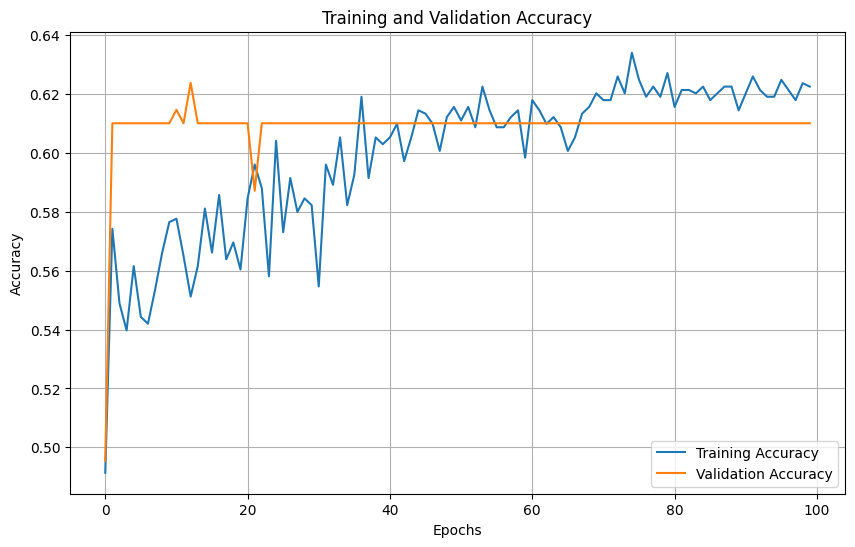

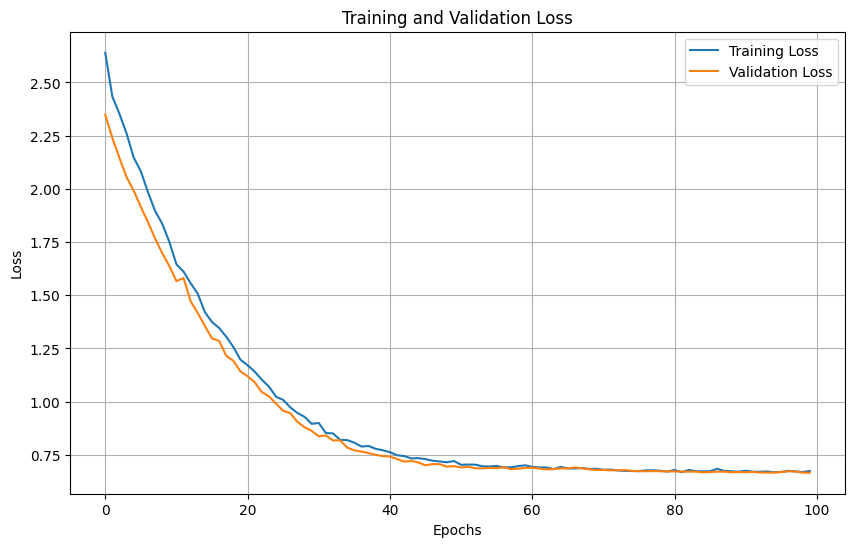

In [37]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## LSTM

In [38]:
data_ind['COVID_Period'] = data_ind['COVID_Period'].astype(int)

time_series_columns = [f'price_{i}_days_before' for i in range(1, 31)]
X_time_series = data_ind[time_series_columns].values.reshape(-1, 30, 1)

static_columns = [
    'dominant_sentiment','Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score',  'COVID_Period', 'Election_Impact_Binary',
]
X_static = data_ind[static_columns].values

y = data_ind['Stock_Direction'].values

X_time_train, X_time_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_time_series, X_static, y, test_size=0.2, random_state=42
)


In [39]:
time_input = Input(shape=(X_time_train.shape[1], X_time_train.shape[2]))  # (30 days, 1 feature)
x = LSTM(64, return_sequences=True)(time_input)  # LSTM layer
x = LSTM(32, return_sequences=False)(x)  # Last LSTM layer
x = Dropout(0.3)(x)  # Dropout to prevent overfitting

static_input = Input(shape=(X_static_train.shape[1],))  # Static features input

combined = Concatenate()([x, static_input])

combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.4)(combined)
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation='sigmoid')(combined)  # Binary classification

lstm_model = Model(inputs=[time_input, static_input], outputs=output)

optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_history = lstm_model.fit(
    [X_time_train, X_static_train], y_train,
    epochs=50, batch_size=32,
    validation_data=([X_time_test, X_static_test], y_test),
    callbacks=[early_stopping],
    verbose=1
)

y_pred_prob = lstm_model.predict([X_time_test, X_static_test])  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc_roc:.4f}")


Epoch 1/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6148 - loss: 0.6812 - val_accuracy: 0.6101 - val_loss: 0.6627
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6295 - loss: 0.6702 - val_accuracy: 0.6101 - val_loss: 0.6647
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6204 - loss: 0.6581 - val_accuracy: 0.6101 - val_loss: 0.6598
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6430 - loss: 0.6577 - val_accuracy: 0.6101 - val_loss: 0.6596
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6107 - loss: 0.6636 - val_accuracy: 0.6101 - val_loss: 0.6557
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6204 - loss: 0.6616 - val_accuracy: 0.6147 - val_loss: 0.6610
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6207 - loss: 0.6568 - val_accuracy: 0.6101 - val_loss: 0.6578
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6385 - loss: 0.6533 - val_accuracy: 0.6101 - val_loss: 0.

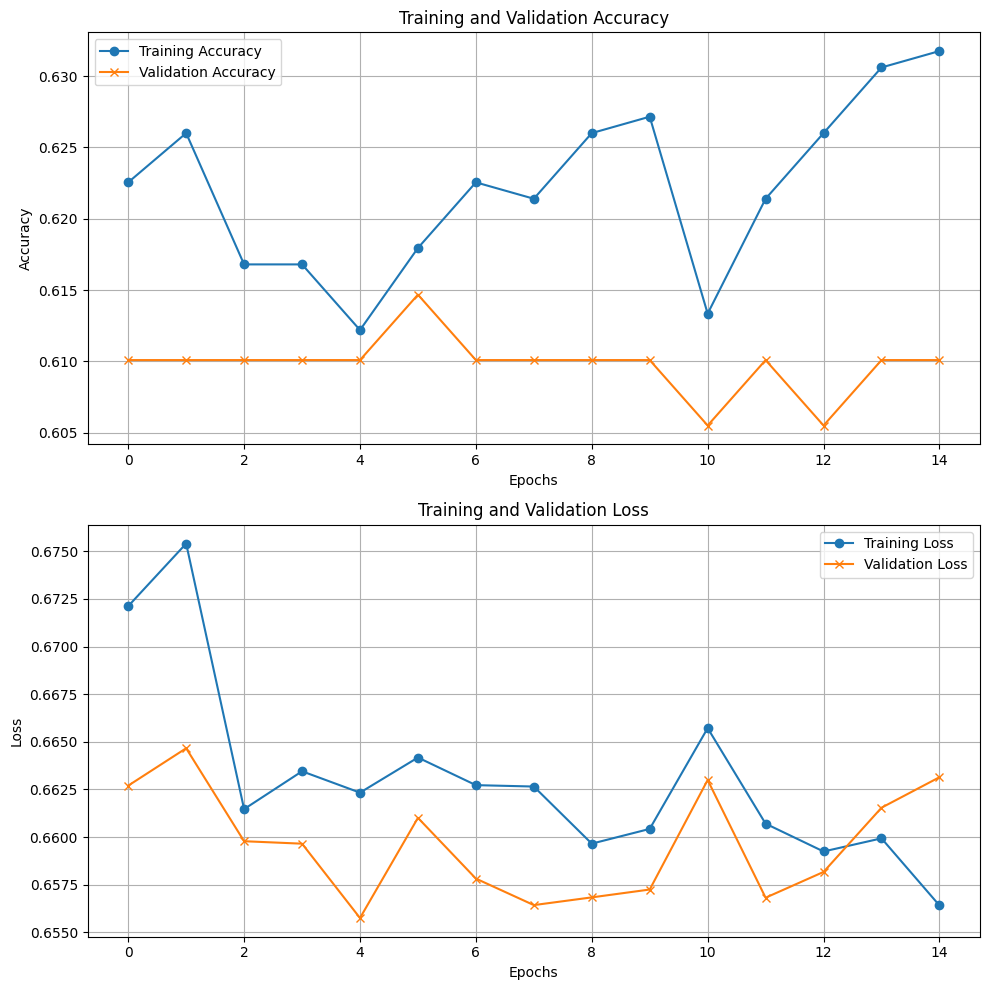

In [40]:

history = lstm_history.history  # Contains 'loss', 'val_loss', 'accuracy', 'val_accuracy'

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(history['accuracy'], label="Training Accuracy", marker='o', linestyle='-')
axes[0].plot(history['val_accuracy'], label="Validation Accuracy", marker='x', linestyle='-')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['loss'], label="Training Loss", marker='o', linestyle='-')
axes[1].plot(history['val_loss'], label="Validation Loss", marker='x', linestyle='-')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [41]:
time_input = Input(shape=(X_time_train.shape[1], X_time_train.shape[2]))  # (30 days, 1 feature)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(time_input)
x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(x)

static_input = Input(shape=(X_static_train.shape[1],))

combined = Concatenate()([x, static_input])

combined = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.4)(combined)

combined = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.4)(combined)

output = Dense(1, activation='sigmoid')(combined)  # Binary classification

lstm_model = Model(inputs=[time_input, static_input], outputs=output)
optimizer = Adam(learning_rate=0.001)

lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

lstm_history = lstm_model.fit(
    [X_time_train, X_static_train], y_train,
    epochs=100, batch_size=64,
    validation_data=([X_time_test, X_static_test], y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

y_pred_prob = lstm_model.predict([X_time_test, X_static_test])
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc_roc:.4f}")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.4911 - loss: 3.1547 - val_accuracy: 0.5917 - val_loss: 2.7425 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5112 - loss: 2.9791 - val_accuracy: 0.6147 - val_loss: 2.6507 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5285 - loss: 2.8123 - val_accuracy: 0.6101 - val_loss: 2.5478 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5209 - loss: 2.7108 - val_accuracy: 0.6101 - val_loss: 2.4583 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5328 - loss: 2.5845 - val_accuracy: 0.6101 - val_loss: 2.3725 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5325 - loss: 2.5047 - val_accuracy: 0.6101 - val_loss: 2.2947 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5153 - loss: 2.4164

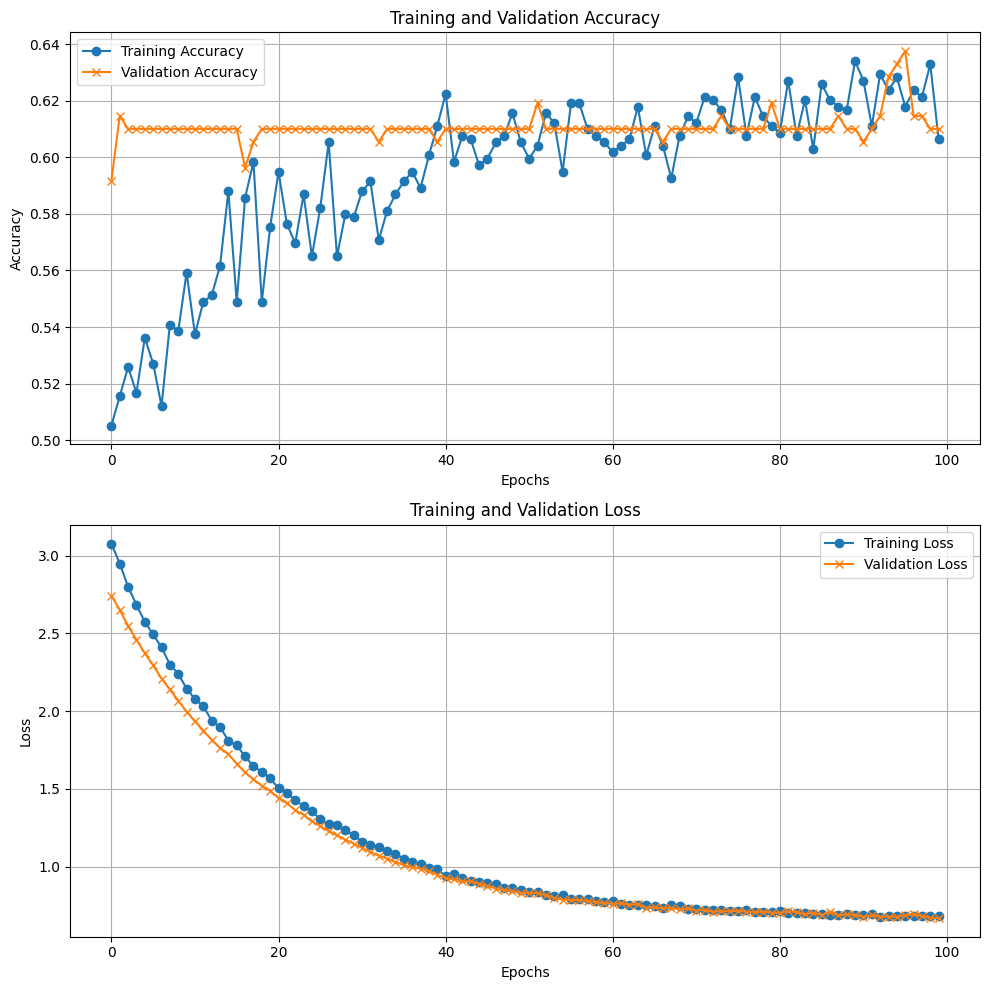

In [42]:
history = lstm_history.history  # Contains 'loss', 'val_loss', 'accuracy', 'val_accuracy'

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(history['accuracy'], label="Training Accuracy", marker='o', linestyle='-')
axes[0].plot(history['val_accuracy'], label="Validation Accuracy", marker='x', linestyle='-')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

# Plot Training and Validation Loss
axes[1].plot(history['loss'], label="Training Loss", marker='o', linestyle='-')
axes[1].plot(history['val_loss'], label="Validation Loss", marker='x', linestyle='-')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].legend()
axes[1].grid(True)

# Show plots
plt.tight_layout()
plt.show()


## LSTM Model Training Performance Analysis

### **Training and Validation Accuracy**
The first plot shows **training and validation accuracy** over **100 epochs**:
- The **training accuracy** (blue line) improves steadily throughout training.
- The **validation accuracy** (orange line) remains relatively high but fluctuates slightly.
- The convergence of training and validation accuracy suggests the model **learns effectively** but still has some **instability around epochs 70-80**.

### **Training and Validation Loss**
The second plot displays the **training and validation loss** trends:
- Both **training loss and validation loss** decrease smoothly over time, indicating **consistent learning**.
- The **small loss gap** suggests that the model generalizes well and is not significantly overfitting.
- Loss stabilizes after around **80 epochs**.


## CNN + RNN

### But why use hyrbid model?

#### Instead of using just RNN, I suggest combining CNN with RNN.
##### - CNN extracts local patterns (like volatility spikes).
##### - RNN learns sequential dependencies (like stock trends over time).
##### - Static features are added separately for better interpretability.

In [43]:
time_input = Input(shape=(30, 1), name="time_input")

cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(time_input)
cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = Flatten()(cnn)  # Convert CNN output to 2D vector

cnn_reshaped = Reshape((30, -1))(cnn)  # Convert back to (batch, timesteps, features)

rnn = SimpleRNN(64, return_sequences=False, dropout=0.3)(cnn_reshaped)  # Use RNN
# rnn = GRU(64, return_sequences=False, dropout=0.3)(cnn_reshaped)  # Use GRU

static_input = Input(shape=(X_static_train.shape[1],), name="static_input")

combined = Concatenate()([rnn, static_input])

combined = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.4)(combined)

combined = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.3)(combined)

output = Dense(1, activation='sigmoid', name="output")(combined)

model = Model(inputs=[time_input, static_input], outputs=output)

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Clip gradients for stability

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=1e-5)

history = model.fit(
    [X_time_train, X_static_train], y_train,  
    epochs=100,
    batch_size=32,
    validation_data=([X_time_test, X_static_test], y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

loss, accuracy = model.evaluate([X_time_test, X_static_test], y_test, verbose=0)

y_pred_prob = model.predict([X_time_test, X_static_test])
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc_roc:.4f}")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5143 - loss: 2.6057 - val_accuracy: 0.4174 - val_loss: 2.3279 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5118 - loss: 2.4423 - val_accuracy: 0.5917 - val_loss: 2.2022 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5418 - loss: 2.2951 - val_accuracy: 0.6101 - val_loss: 2.1121 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5236 - loss: 2.2554 - val_accuracy: 0.6101 - val_loss: 1.9983 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5298 - loss: 2.0807 - val_accuracy: 0.6101 - val_loss: 1.9166 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5325 - loss: 2.0086 - val_accuracy: 0.6101 - val_loss: 1.8335 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5501 - loss: 1.9182 - val_ac

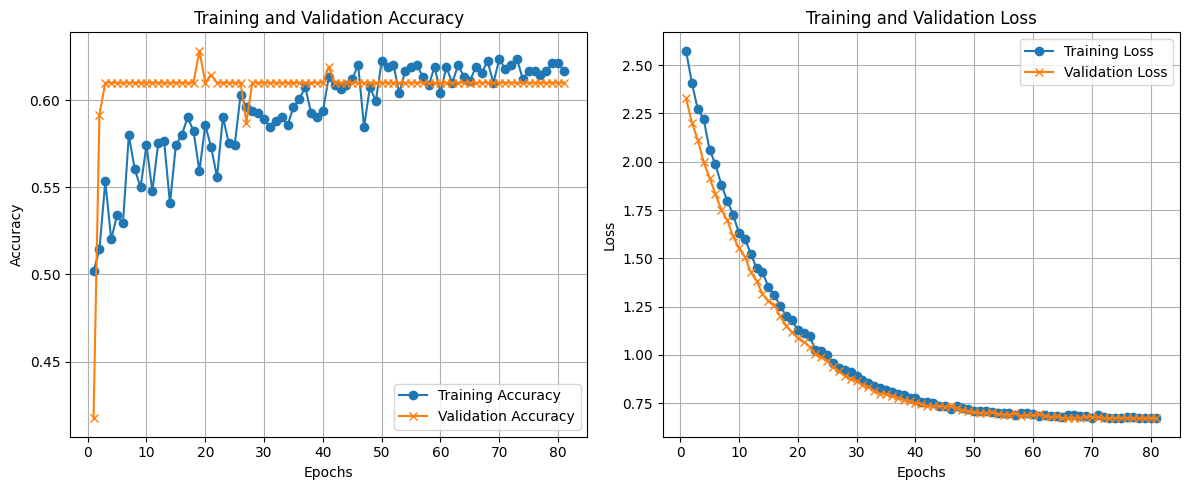

In [44]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label="Training Accuracy", marker='o', linestyle='-')
plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", marker='x', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label="Training Loss", marker='o', linestyle='-')
plt.plot(epochs, history.history['val_loss'], label="Validation Loss", marker='x', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## FI

                       Feature  Importance
5          price_1_days_before    0.074794
6          price_2_days_before    0.060513
1   Prepared_remarks_Pos_Score    0.043226
7          price_3_days_before    0.040039
8          price_4_days_before    0.039509
2   Prepared_remarks_Neg_Score    0.039242
34        price_30_days_before    0.035012
30        price_26_days_before    0.033960
31        price_27_days_before    0.033576
33        price_29_days_before    0.032293


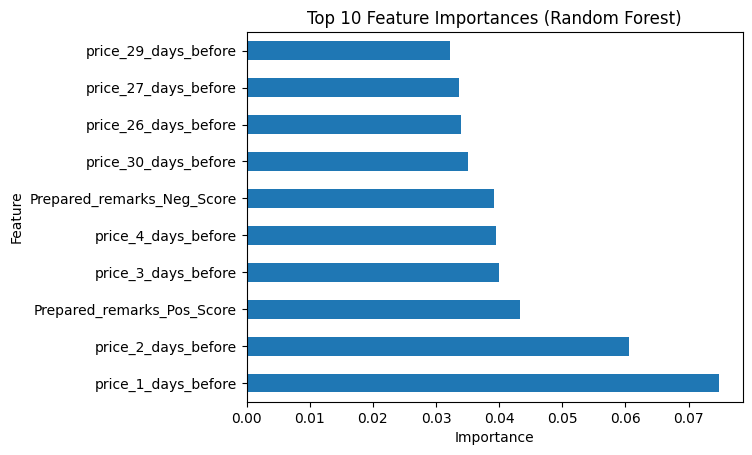

In [45]:
features_with_sentiment = [
    'dominant_sentiment', 'Prepared_remarks_Pos_Score', 'Prepared_remarks_Neg_Score',
    'COVID_Period', 'Election_Impact_Binary',
] + [f'price_{i}_days_before' for i in range(1, 31)]
X = data_ind[features_with_sentiment]
y = data_ind['Stock_Direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features_with_sentiment,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

# Visualize feature importance
import matplotlib.pyplot as plt
feature_importance_df[:10].plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()


## T Tests

In [46]:
with_sentiment = [0.57, 0.76, 0.64, 0.61]  # LSTM, GRU, CNN, RNN
without_sentiment = [0.52, 0.70, 0.61, 0.57]

t_stat, p_value = ttest_rel(with_sentiment, without_sentiment)

print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference is statistically significant. Sentiment features improve model performance.")
else:
    print("The difference is NOT statistically significant.")


T-Statistic: 6.9714, P-Value: 0.0061
The difference is statistically significant. Sentiment features improve model performance.


In [47]:
before_covid = data_ind[data_ind['COVID_Period'] == False]['Stock_Change']
during_covid = data_ind[data_ind['COVID_Period'] == True]['Stock_Change']

t_stat, p_value = ttest_rel(before_covid[:len(during_covid)], during_covid)

print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")


if p_value < 0.05:
    print("Stock changes before and during COVID differ significantly.")
else:
    print("No significant difference in stock changes before and during COVID.")


T-Statistic: 0.8819, P-Value: 0.3784
No significant difference in stock changes before and during COVID.


# __________________________________________________________________________________________________________________________________________________________________